# Algorithm 3 from Neal (2000)

Implementation of the algorithm 3 form Neal (2000). With a Normal-Inverse-Wishart prior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import random
import copy
from tqdm import tqdm
import pickle

Imports from our own code files :

In [2]:
import sys, os
sys.path.insert(0, os.path.dirname(os.path.abspath('../../main_code')))
from main_code.neal_algorithm_3 import algorithm_3, save_data, load_data
from main_code.partitions_analysis import *
from main_code.data_generation import generate_gaussian_mixture
from main_code.visualization import *
from main_code.integrals_without_covariates import *

## 1. Functions for our assumptions

Define function to compute likelihood of some observation belonging to a given cluster given our assumptions

In [3]:
# These functions change based on assumption on the prior parameters of the model
def compute_mu_0(Y):
    return np.mean(Y, axis=0)   # default to mean of data, reasonable assumption

def compute_nu_0(D):
    #! changed to D+3 from D+1 as suggested in last meeting
    return D + 3    # default to D, potentially change this

def compute_inv_scale_mat_0(D):
    return np.eye(D)    # default to identity, potentially change this

def compute_lamb_0(Y):
    #! changed to a value smaller then 1 as suggested in last meeting
    return 0.75    # default to 1, potentially change this


## 2. Test with synthetic data

Generate and visualize synthethic data

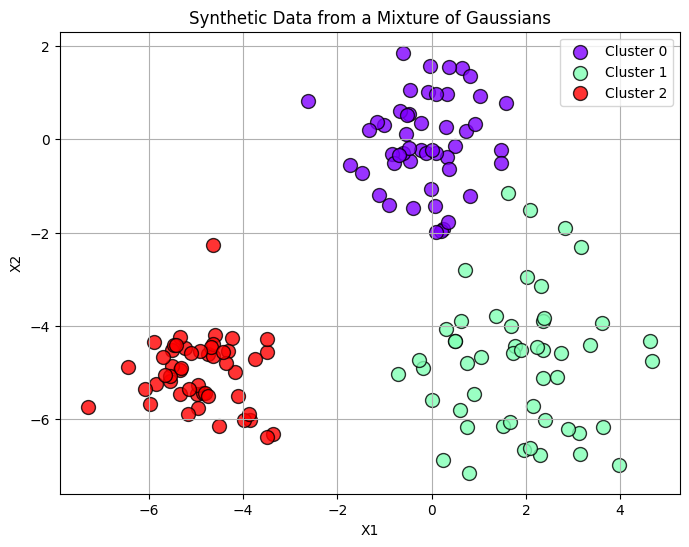

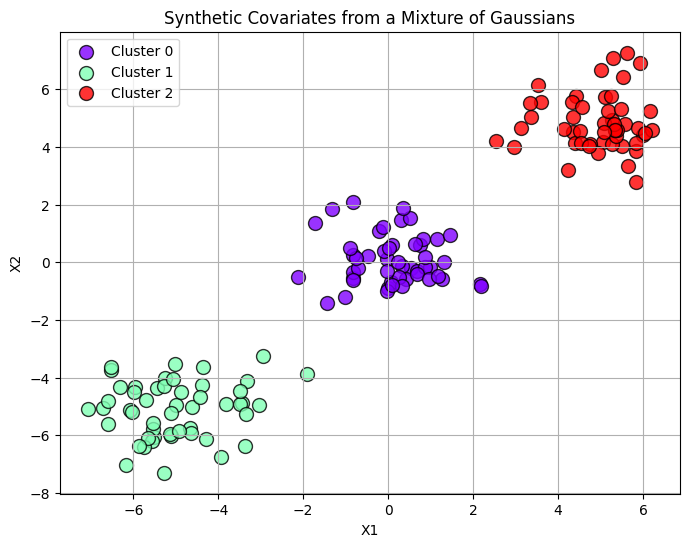

In [8]:
# Sample syntethic
np.random.seed(42)  # for reproducibility
random.seed(42)

# Y
means = [[0, 0], [2, -5], [-5, -5]]
covariances = [np.eye(2), 2 * np.eye(2), 0.5 * np.eye(2)]
n_samples = [50, 50, 50]

Y, labels = generate_gaussian_mixture(means, covariances, n_samples)

plot_clusters(Y, labels, "Synthetic Data from a Mixture of Gaussians")


# X
means_X = [[0, 0], [-5, -5], [5, 5]]
covariances_X = [np.eye(2), np.eye(2), np.eye(2)]

X, _ = generate_gaussian_mixture(means_X, covariances_X, n_samples)

plot_clusters(X, labels, "Synthetic Covariates from a Mixture of Gaussians")

Apply algorithm 3 on synthetic data and visualize result

Markov Chain Progress: 100%|██████████| 300/300 [02:56<00:00,  1.70step/s]


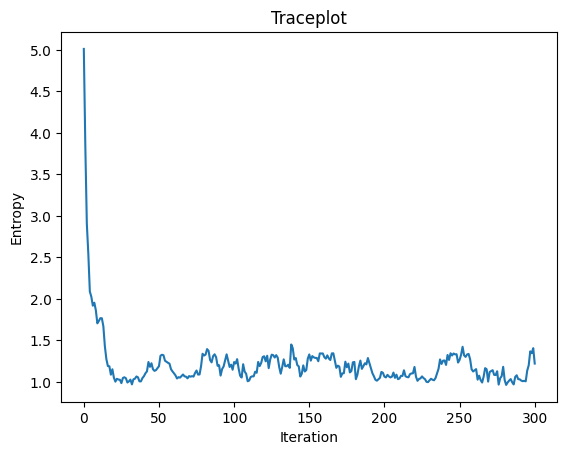

In [16]:
# Trying our clustering algorithm without covariates
n_steps = 300
burn_in = 50
alpha = 1
history, entropies = algorithm_3(n_steps,
                      Y,
                      X,
                      integral_func_1,
                      integral_func_2,
                      alpha=alpha,
                      compute_nu_0=compute_nu_0,
                      compute_lamb_0=compute_lamb_0,
                      visualize_entropy=True,
                      lambda_penalty=0.0)

## 3. Point estimate

Compute the similarity matix as a summary for the MCMC

In [17]:
S = sampled_sim_matrix(history[burn_in:], len(Y))

Compute a point estimate as the final result of the MCMC.

In [18]:
optimal_clustering, optimal_loss = find_optimal_clustering_binder_loss(history[burn_in:], S, alpha=1.0, beta=1.0)

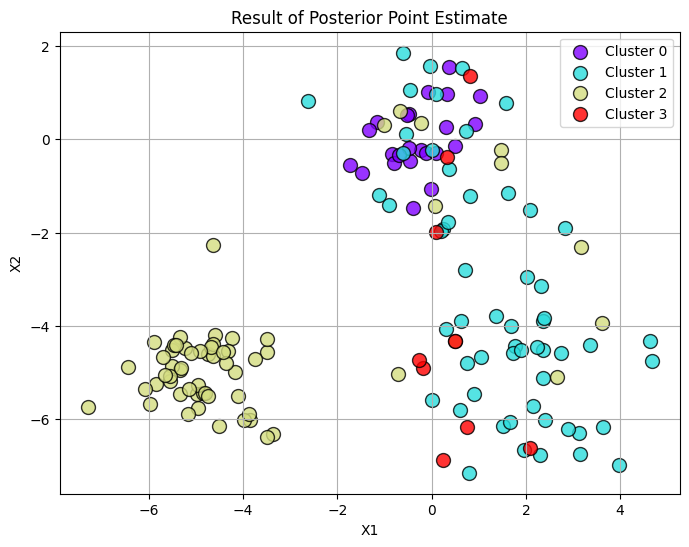

In [19]:
plot_clusters(Y, optimal_clustering, "Result of Posterior Point Estimate")